## Importing packages and data

In [1]:
import glob, os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import seaborn as sns
from colav.extract_data import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/umap/dist

In [2]:
# sns.set_palette(sns.color_palette("Dark2"))

In [3]:
plt.rcParams["font.size"] = 14
# plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "regular"

In [4]:
theseus_strucs = sorted(glob.glob("mpro_data/mpro_theseus_data/*pdb"))
resnum_bounds = (3, 297)

In [5]:
# untreated dihedral data processing
# untreated_dihedrals, dihedral_strucs = generate_dihedral_matrix(theseus_strucs,
#                                                                 resnum_bounds,
#                                                                 save=True,
#                                                                 save_prefix='mpro_data/mpro',
#                                                                 verbose=True)
untreated_dihedrals, dihedral_strucs = load_dihedral_matrix(
    "mpro_data/mpro_dh_dict.pkl"
)
untreated_dihedrals_data = np.hstack(
    [np.sin(untreated_dihedrals), np.cos(untreated_dihedrals)]
)

In [6]:
# rope dihedral data processing
rope_dihedrals = pd.read_csv("mpro_data/filtered-mpro.csv")
rope_strucs = np.array([x[:-2] for x in rope_dihedrals.Name.values])

In [7]:
# pairwise distances data processing
# pw_data, pw_strucs = generate_pw_matrix(theseus_strucs,
#                                         resnum_bounds,
#                                         save=True,
#                                         save_prefix='mpro_data/mpro',
#                                         verbose=False)
pw_data, pw_strucs = load_pw_matrix("mpro_data/mpro_pw_dict.pkl")

In [8]:
# strain data processing
# sa_data, sa_strucs = generate_strain_matrix(theseus_strucs,
#                                             '../data/mpro_theseus_data/theseus_7ar5_chainA.pdb',
#                                             'sheart',
#                                             resnum_bounds,
#                                             save=True,
#                                             save_prefix='mpro_data/mpro',
#                                             verbose=False)
sa_data, sa_strucs = load_strain_matrix("mpro_data/mpro_sa_sheart_dict.pkl")

In [9]:
md_list = ["7mhl", "7mhm", "7mhn", "7mho", "7mhp", "7mhq"]
dihedral_strucs_no_md = list()
untreated_dihedrals_data_no_md = list()
for i in np.arange(len(dihedral_strucs)):
    if os.path.basename(dihedral_strucs[i]).split("_")[1] in md_list:
        continue

    dihedral_strucs_no_md.append(dihedral_strucs[i])
    untreated_dihedrals_data_no_md.append(untreated_dihedrals_data[i, :])
del dihedral_strucs
del untreated_dihedrals_data
untreated_dihedrals_data_no_md = np.array(untreated_dihedrals_data_no_md).reshape(
    len(dihedral_strucs_no_md), -1
)

In [10]:
md_list = ["7mhl", "7mhm", "7mhn", "7mho", "7mhp", "7mhq"]
drop_list = list()
for md in md_list: 
    for i,rope in enumerate(rope_strucs): 
        if md in rope: 
            drop_list.append(i)
rope_dihedrals.drop(index=drop_list, axis=0, inplace=True)
rope_strucs = np.array([x[:-2] for x in rope_dihedrals.Name.values])
rope_dihedrals.drop(['Unnamed: 0', 'Name'], axis=1, inplace=True)
rope_dihedrals = np.deg2rad(rope_dihedrals.values)
rope_dihedrals_data = np.hstack([np.sin(rope_dihedrals),
                                 np.cos(rope_dihedrals)])

In [11]:
md_list = ["7mhl", "7mhm", "7mhn", "7mho", "7mhp", "7mhq"]
pw_strucs_no_md = list()
pw_data_no_md = list()
for i in np.arange(len(pw_strucs)):
    if os.path.basename(pw_strucs[i]).split("_")[1] in md_list:
        continue

    pw_strucs_no_md.append(pw_strucs[i])
    pw_data_no_md.append(pw_data[i, :])
del pw_strucs
del pw_data
pw_data_no_md = np.array(pw_data_no_md).reshape(len(pw_strucs_no_md), -1)

In [12]:
md_list = ["7mhl", "7mhm", "7mhn", "7mho", "7mhp", "7mhq"]
sa_strucs_no_md = list()
sa_data_no_md = list()
for i in np.arange(len(sa_strucs)):
    if os.path.basename(sa_strucs[i]).split("_")[1] in md_list:
        continue

    sa_strucs_no_md.append(sa_strucs[i])
    sa_data_no_md.append(sa_data[i, :])
del sa_strucs
del sa_data
sa_data_no_md = np.array(sa_data_no_md).reshape(len(sa_strucs_no_md), -1)

In [13]:
# Dihedral PCA
# untreated
u_pca = PCA(n_components=10)
u_A = u_pca.fit_transform(untreated_dihedrals_data_no_md)
# rope
rope_pca = PCA(n_components=10)
rope_A = rope_pca.fit_transform(rope_dihedrals_data)
u_pca.explained_variance_ratio_, rope_pca.explained_variance_ratio_

(array([0.14409827, 0.06982255, 0.05798785, 0.04830355, 0.03740501,
        0.03486157, 0.02715506, 0.02007713, 0.01734791, 0.01658403]),
 array([0.14218803, 0.09039514, 0.06030583, 0.04293284, 0.03135901,
        0.02943227, 0.02545648, 0.01923876, 0.01660633, 0.01185213]))

In [14]:
# Pairwise Distance PCA
pw_pca = PCA(n_components=10)
pw_A = pw_pca.fit_transform(pw_data_no_md)
pw_pca.explained_variance_ratio_

array([0.35679292, 0.20511962, 0.08429778, 0.06392645, 0.03888031,
       0.02746678, 0.01893177, 0.01596673, 0.01410785, 0.01206021])

In [15]:
# Strain Analysis PCA
sa_pca = PCA(n_components=10)
sa_A = sa_pca.fit_transform(sa_data_no_md)
sa_pca.explained_variance_ratio_

array([0.30439007, 0.09570106, 0.05311715, 0.04193312, 0.03277202,
       0.03161652, 0.0277554 , 0.02160742, 0.01719445, 0.0160743 ])

In [16]:
mpro_ss_dict = {
    u'\u03b11': (11,16), 
    u'\u03b21': (17,22),
    u'\u03b22': (25,32),
    u'\u03b23': (35,39),
    u'\u03b12': (40,43),
    u'\u03b13': (46,49),
    u'\u03b14': (54,60),
    u'\u03b15': (63,65),
    u'\u03b24': (67,69),
    u'\u03b25': (77,82),
    u'\u03b26': (86,91),
    u'\u03b27': (101,104),
    u'\u03b28': (109,118),
    u'\u03b29': (121,131),
    u'\u03b210': (134,136),
    u'\u03b211': (146,153),
    u'\u03b212': (156,167),
    u'\u03b213': (170,175),
    u'\u03b16': (201,214),
    u'\u03b17': (244,256),
    u'\u03b18': (261,274),
    u'\u03b19': (293,298),
}

## Main text figures

In [17]:
km = KMeans(n_clusters=8, random_state=0).fit(untreated_dihedrals_data_no_md)

/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


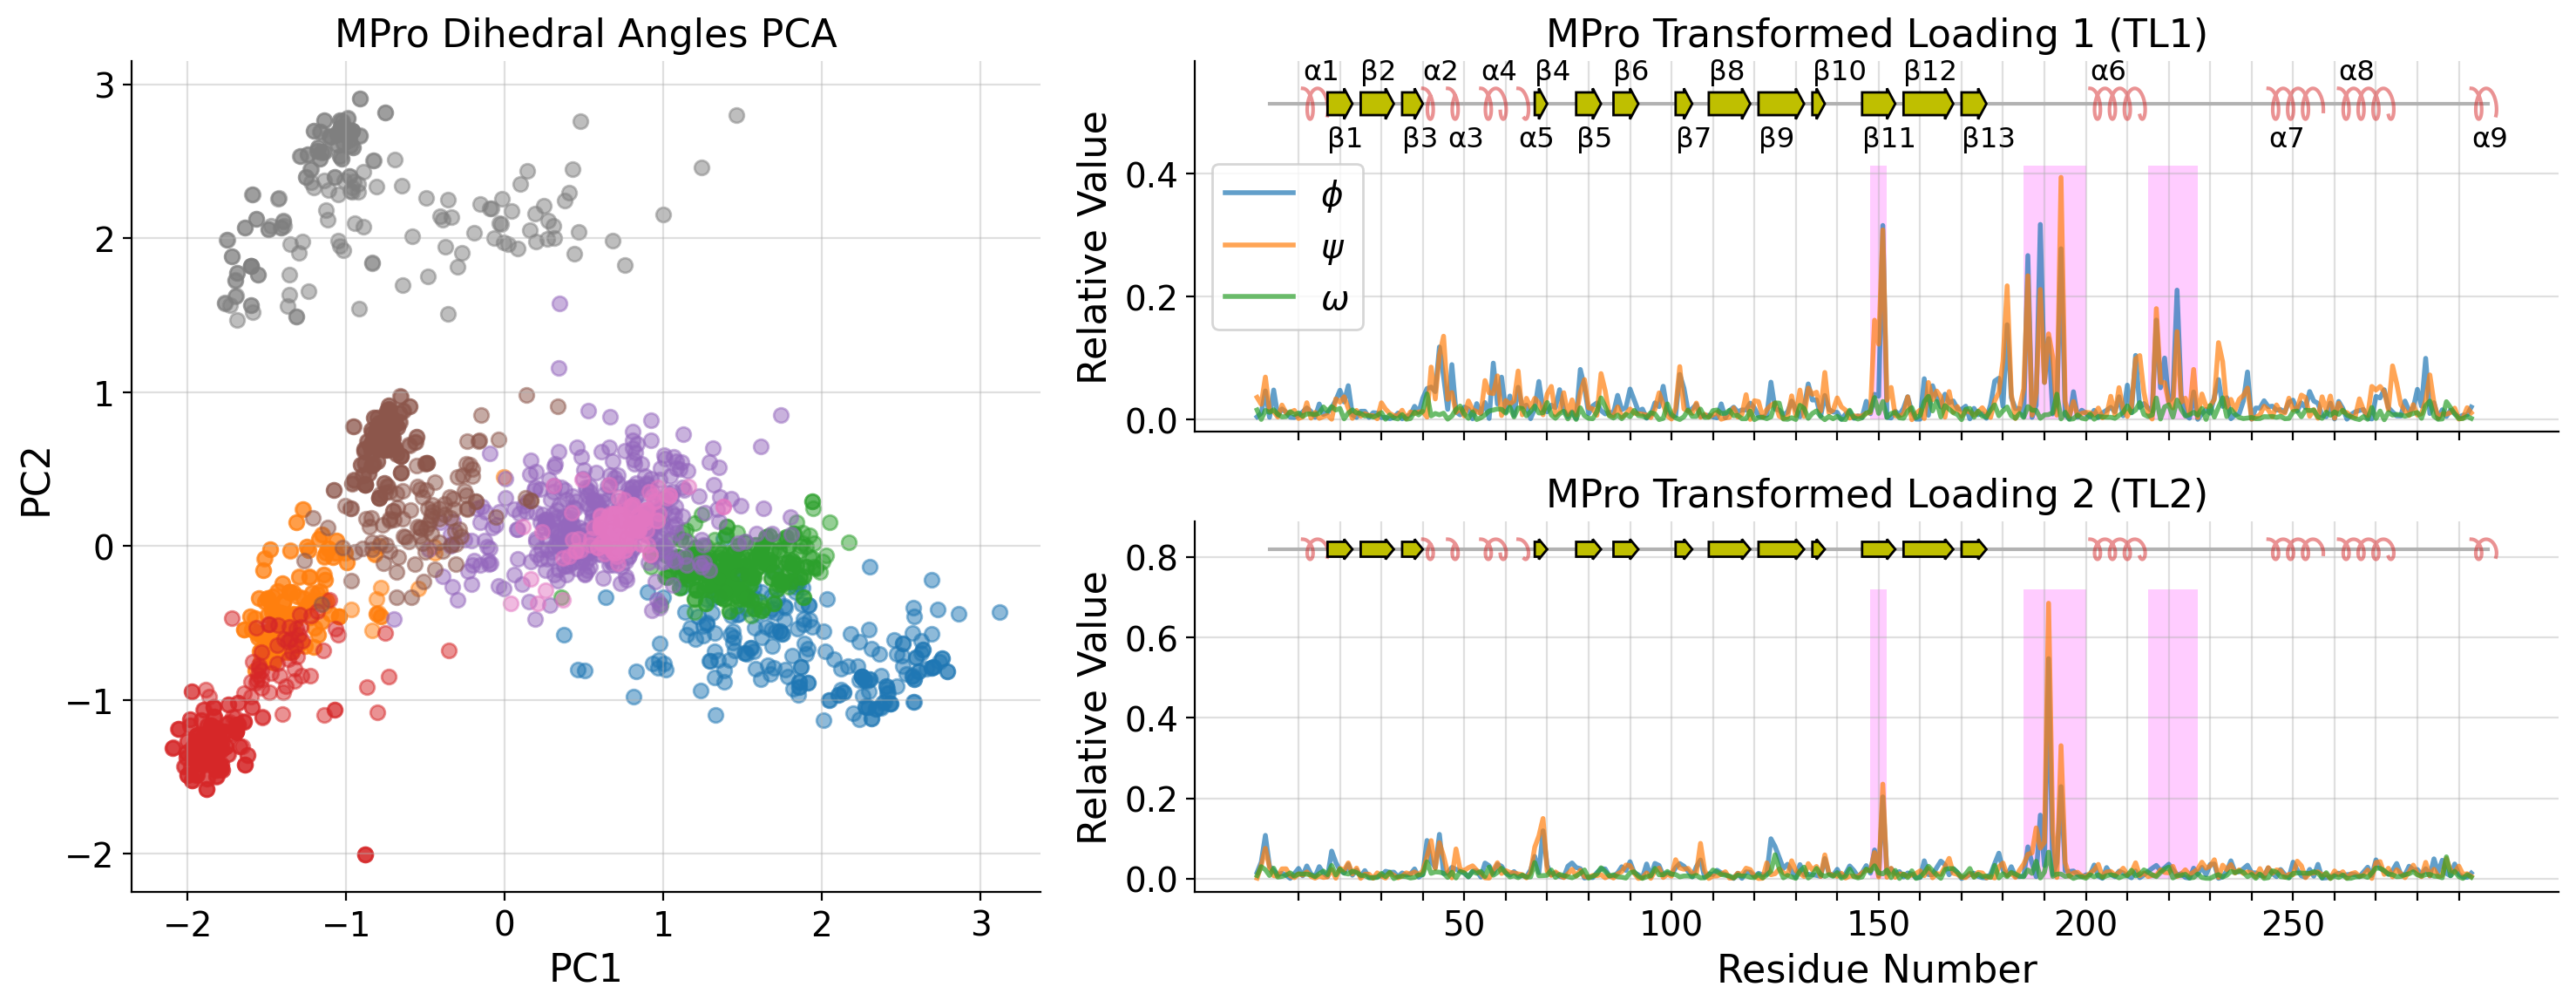

In [18]:
gs_kw = dict(width_ratios=[1, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic(
    [["left", "upper right"], ["left", "lower right"]],
    gridspec_kw=gs_kw,
    figsize=(15, 6),
    layout="constrained",
    dpi=200,
)

for i, ax in enumerate(axd):
    axd[ax].spines['top'].set_visible(False)
    axd[ax].spines['right'].set_visible(False)
    axd[ax].grid(alpha=0.4)
    
    if i == 0:
        for j in np.arange(8): 
            axd[ax].scatter(
                u_A[km.labels_ == j,0],
                u_A[km.labels_ == j,1],
                marker="o",
                alpha=0.5,
                edgecolor=None,
            )
        axd[ax].set_ylabel("PC2")
        axd[ax].set_xlabel("PC1")
        axd[ax].set_title("MPro Dihedral Angles PCA")

    else:
        psi_idx = np.arange(0, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
        omg_idx = np.arange(1, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
        phi_idx = np.arange(2, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
        dh_range = np.arange(resnum_bounds[0], resnum_bounds[1] + 1)
        (phi_trace,) = axd[ax].plot(
            calculate_dh_tl(u_pca.components_[i - 1])[phi_idx],
            "-",
            label=r"$\phi$",
            linewidth=2,
            alpha=0.7,
        )
        (psi_trace,) = axd[ax].plot(
            calculate_dh_tl(u_pca.components_[i - 1])[psi_idx],
            "-",
            label=r"$\psi$",
            linewidth=2,
            alpha=0.7,
        )
        (omg_trace,) = axd[ax].plot(
            calculate_dh_tl(u_pca.components_[i - 1])[omg_idx],
            "-",
            label=r"$\omega$",
            linewidth=2,
            alpha=0.7,
        )
        ylims = axd[ax].get_ylim()
        axd[ax].set_title(f"MPro Transformed Loading {i} (TL{i})")
        axd[ax].set_xticks(
            [dh for dh in dh_range if dh % 10 == 0],
            labels=[dh if dh % 50 == 0 else '' for dh in dh_range if dh % 10 == 0],
        )
        axd[ax].add_patch(
            Rectangle(
                (148, 0),
                width=4,
                height=axd[ax].get_ylim()[1], # residues 148-152
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].add_patch(
            Rectangle(
                (185, 0),
                width=15,
                height=axd[ax].get_ylim()[1], # linker residues 185-200
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].add_patch(
            Rectangle(
                (215, 0),
                width=12,
                height=axd[ax].get_ylim()[1], # residues 215-227
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].plot(np.arange(3,298), [ylims[1]+0.1]*295, alpha=0.3, color='k', linestyle='-', zorder=1)
        counter = 0
        for k,v in mpro_ss_dict.items(): 
            if k.startswith(u'\u03b1'): 
                ts = np.linspace(v[0], v[1], num=1000)
                axd[ax].plot(ts + 1.5*np.sin((ts-v[0])*2*np.pi/3.6), 0.025*np.cos((ts-v[0])*2*np.pi/3.6)+ylims[1]+0.1, color='tab:red', alpha=0.5, zorder=2)
                if ax == 'upper right': 
                    axd[ax].text(v[0], ylims[1]+0.14 if counter%2 == 0 else ylims[1]+0.03, k, fontsize='small')
                    counter += 1
            else: 
                axd[ax].arrow(v[0],ylims[1]+0.1,v[1]-v[0]+1,0, width=0.037, head_width=0.05, head_length=2, fc='y', length_includes_head=True, zorder=3)
                if ax == 'upper right': 
                    axd[ax].text(v[0], ylims[1]+0.14 if counter%2 == 0 else ylims[1]+0.03, k, fontsize='small')
                    counter += 1
        axd[ax].set_ylim((ylims[0], ylims[1]+0.17))
        axd[ax].set_ylabel("Relative Value")
axd["upper right"].set_xticklabels([])
axd["upper right"].legend(loc="center left")
axd["lower right"].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

/var/folders/54/1s2b91zs4tl3crj4c9hd8h580000gn/T/ipykernel_45295/1087464761.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


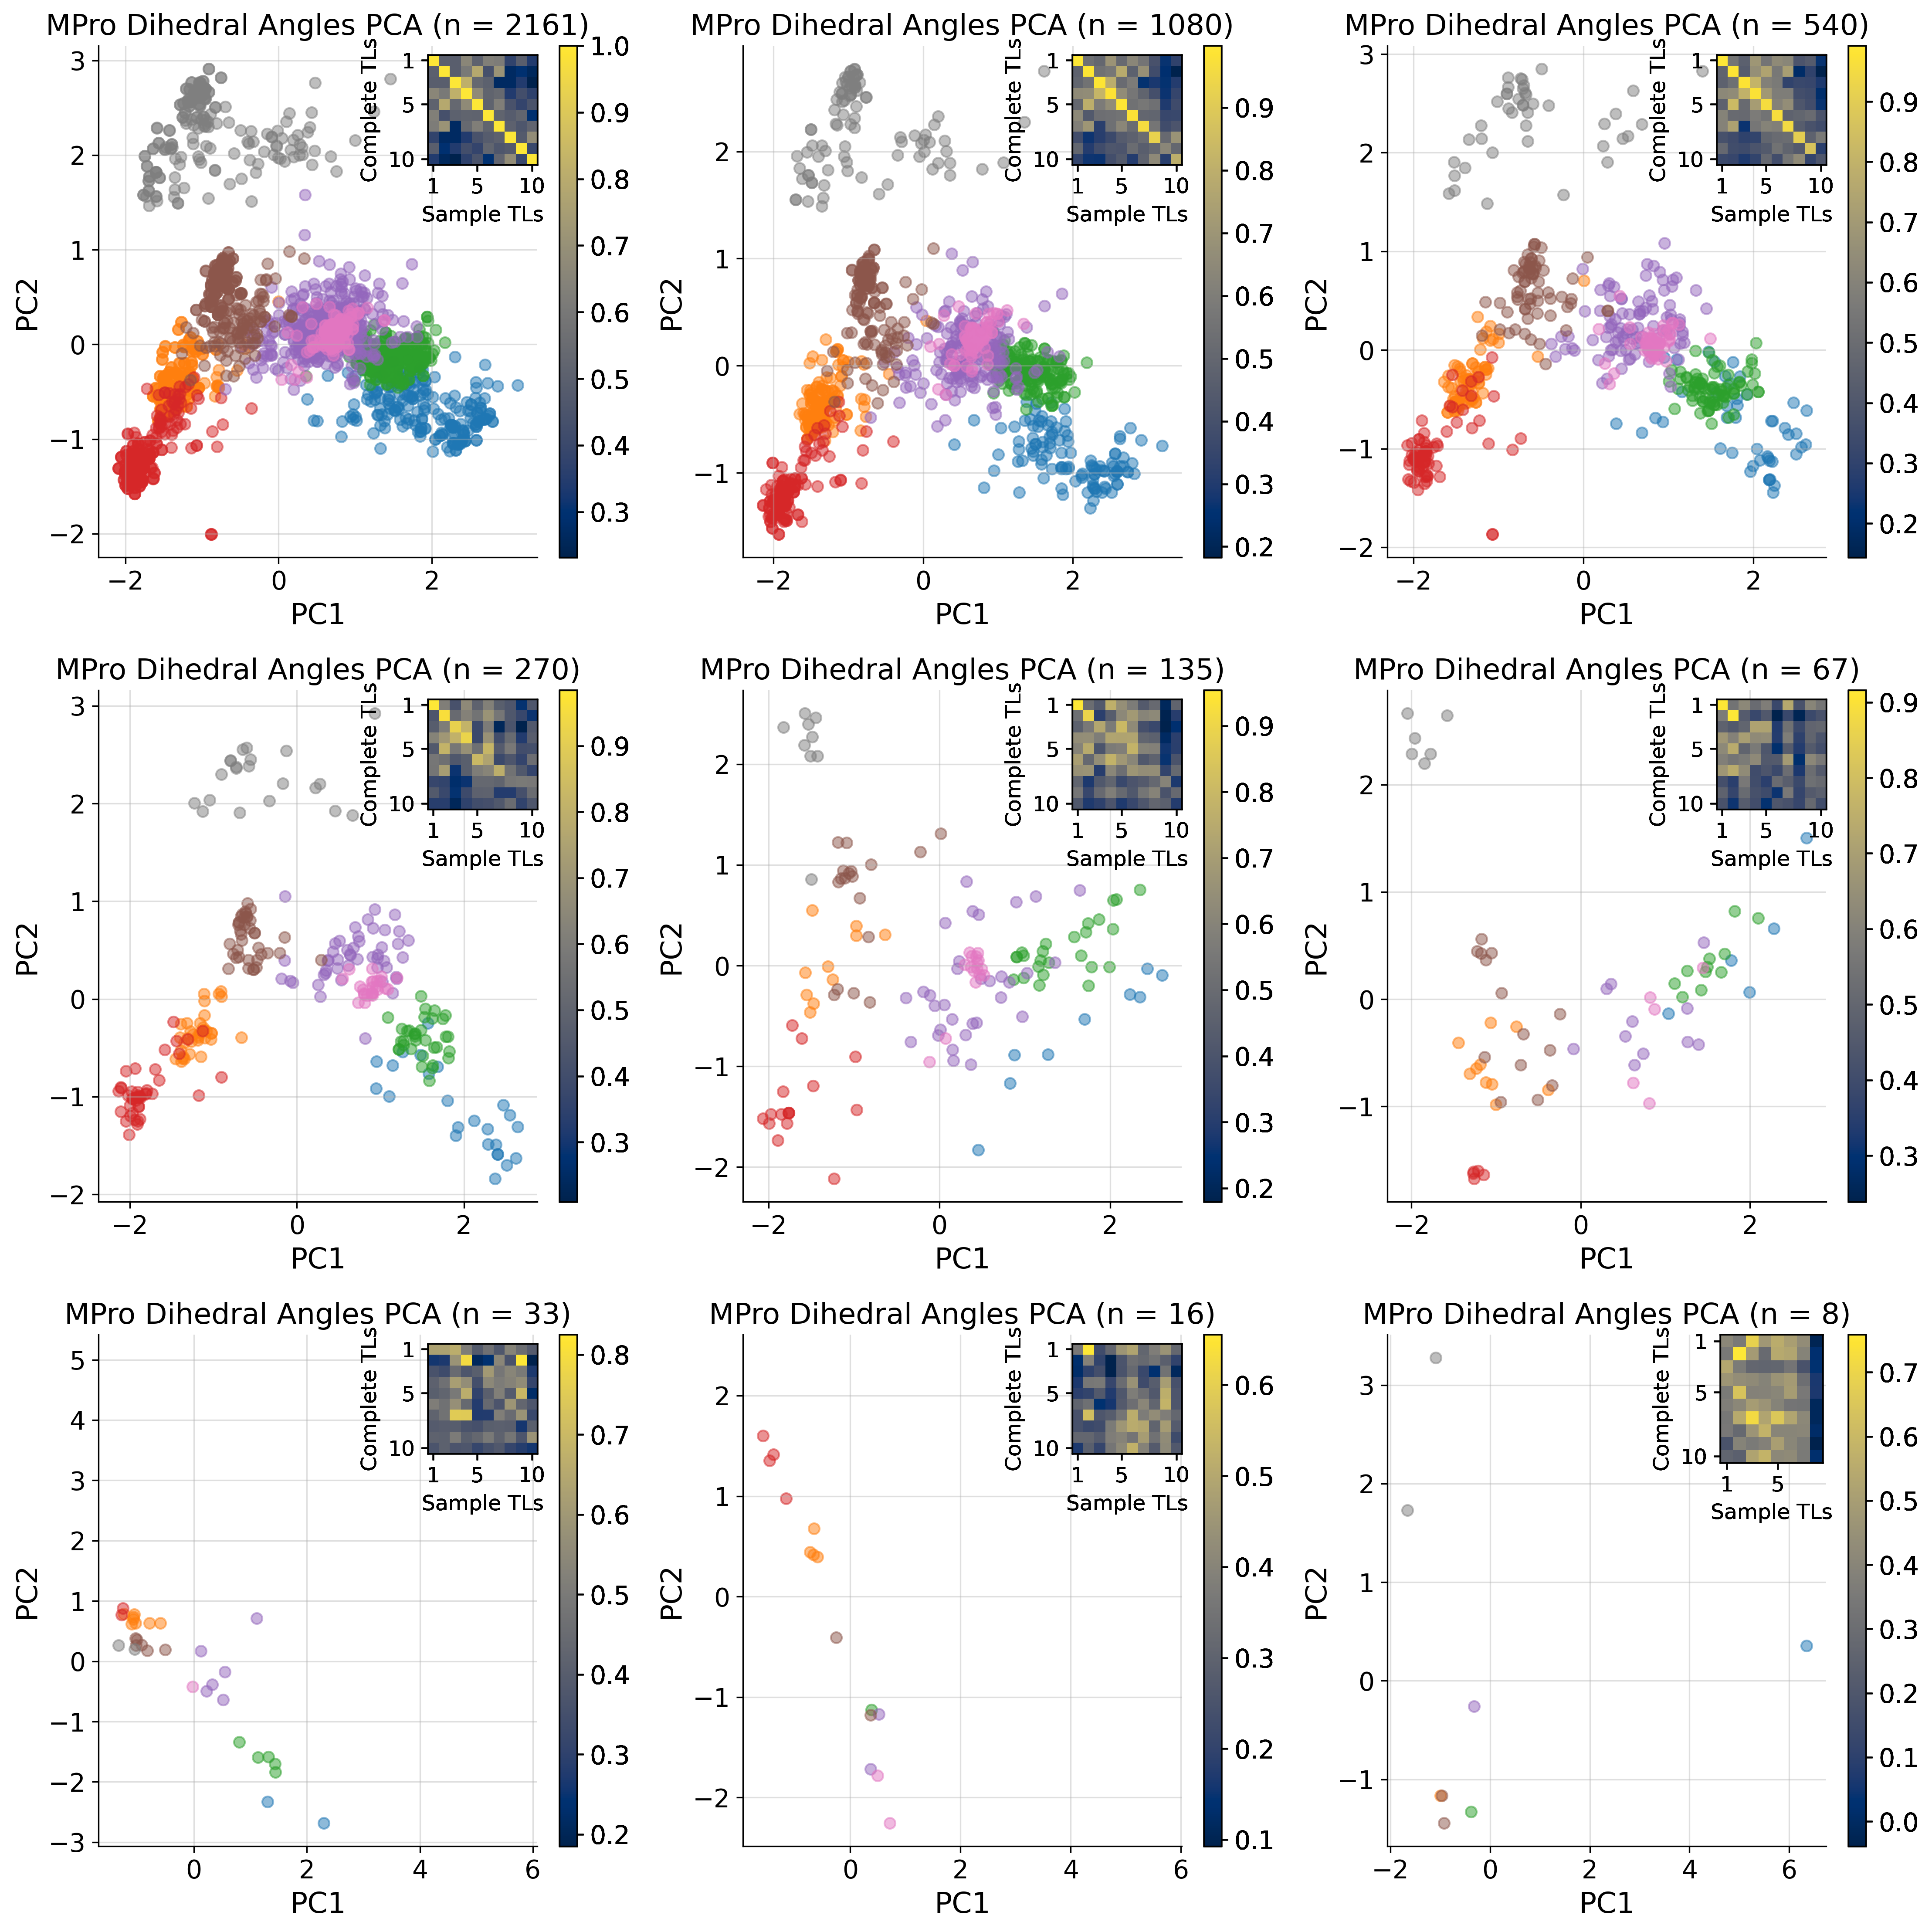

In [19]:
# sampling MPro structures for minimum working number
fig, ax = plt.subplots(3,3,figsize=(15,15),dpi=300)
ax = ax.flatten()
rng = np.random.default_rng(seed=0)
for i in np.arange(9): 
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(alpha=0.4)
    
    # access random sample of structures
    samples = untreated_dihedrals_data_no_md.shape[0]//np.power(2, i)
    sample_idxs = rng.choice(untreated_dihedrals_data_no_md.shape[0], size=samples, replace=False)
    
    # fit a PCA model to the samples using dihedral angles (untreated by RoPE)
    sample_untreated_dihedrals_data_no_md = untreated_dihedrals_data_no_md[sample_idxs]
    sample_labels = km.labels_[sample_idxs]
    sample_pca = PCA(n_components=10 if samples >= 10 else samples)
    sample_transform = sample_pca.fit_transform(sample_untreated_dihedrals_data_no_md)
    
    # calculate correlation matrix of the complete dataset and sample dataset; first panel is complete dataset 
    sample_matrix = list()
    for j in np.arange(10): 
        for k in np.arange(10) if samples >= 10 else np.arange(samples): 
            sample_matrix.append(
                pearsonr(
                    calculate_dh_tl(u_pca.components_[j, :])[psi_idx]
                    + calculate_dh_tl(u_pca.components_[j, :])[phi_idx]
                    + calculate_dh_tl(u_pca.components_[j, :])[omg_idx],
                    calculate_dh_tl(sample_pca.components_[k, :])[psi_idx]
                    + calculate_dh_tl(sample_pca.components_[k, :])[phi_idx]
                    + calculate_dh_tl(sample_pca.components_[k, :])[omg_idx]
                )[0]
            )
    sample_matrix = np.array(sample_matrix).reshape(10,10 if samples >= 10 else samples)
    
    # plot the PCA space (PC1 + PC2) w/ colors of previous plots
    for j in np.arange(8): 
        ax[i].scatter(
            sample_transform[sample_labels == j,0],
            sample_transform[sample_labels == j,1],
            marker="o",
            alpha=0.5,
            edgecolor=None,
        )
        ax2 = plt.axes([0,0,1,1])
        ax2.set_xlabel('Sample TLs', fontsize='small')
        ax2.set_ylabel('Complete TLs', fontsize='small')
        ax2.set_xticks([0,4,9],[1,5,10], fontsize='small')
        ax2.set_yticks([0,4,9],[1,5,10], fontsize='small')
        ip = InsetPosition(ax[i], [0.75,0.75,0.25,0.25])
        ax2.set_axes_locator(ip)
        im = ax2.imshow(sample_matrix, cmap="cividis", interpolation=None)
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", "4%", pad="5%")
        plt.colorbar(im, cax=cax)
    ax[i].set_ylabel("PC2")
    ax[i].set_xlabel("PC1")
    ax[i].set_title(f"MPro Dihedral Angles PCA (n = {samples})")
    
plt.tight_layout()
plt.show()

In [20]:
# fragment screen only and PDB only PCA
fragment_strucs_no_md = list()
fragment_dihedrals_data_no_md = list()
fragment_labels = list()
pdb_strucs_no_md = list()
pdb_dihedrals_data_no_md = list()
pdb_labels = list()

# split the datasets 
for i,k in enumerate(dihedral_strucs_no_md): 
    if os.path.basename(k).split("_")[1][0] > "A": 
        fragment_strucs_no_md.append(k)
        fragment_dihedrals_data_no_md.append(untreated_dihedrals_data_no_md[i,:])
        fragment_labels.append(km.labels_[i])
    else: 
        pdb_strucs_no_md.append(k)
        pdb_dihedrals_data_no_md.append(untreated_dihedrals_data_no_md[i,:])
        pdb_labels.append(km.labels_[i])
        
fragment_dihedrals_data_no_md = np.array(fragment_dihedrals_data_no_md)
pdb_dihedrals_data_no_md = np.array(pdb_dihedrals_data_no_md)

# calculate PCA
fragment_pca = PCA(n_components=10)
fragment_A = fragment_pca.fit_transform(fragment_dihedrals_data_no_md)

pdb_pca = PCA(n_components=10)
pdb_A = pdb_pca.fit_transform(pdb_dihedrals_data_no_md)

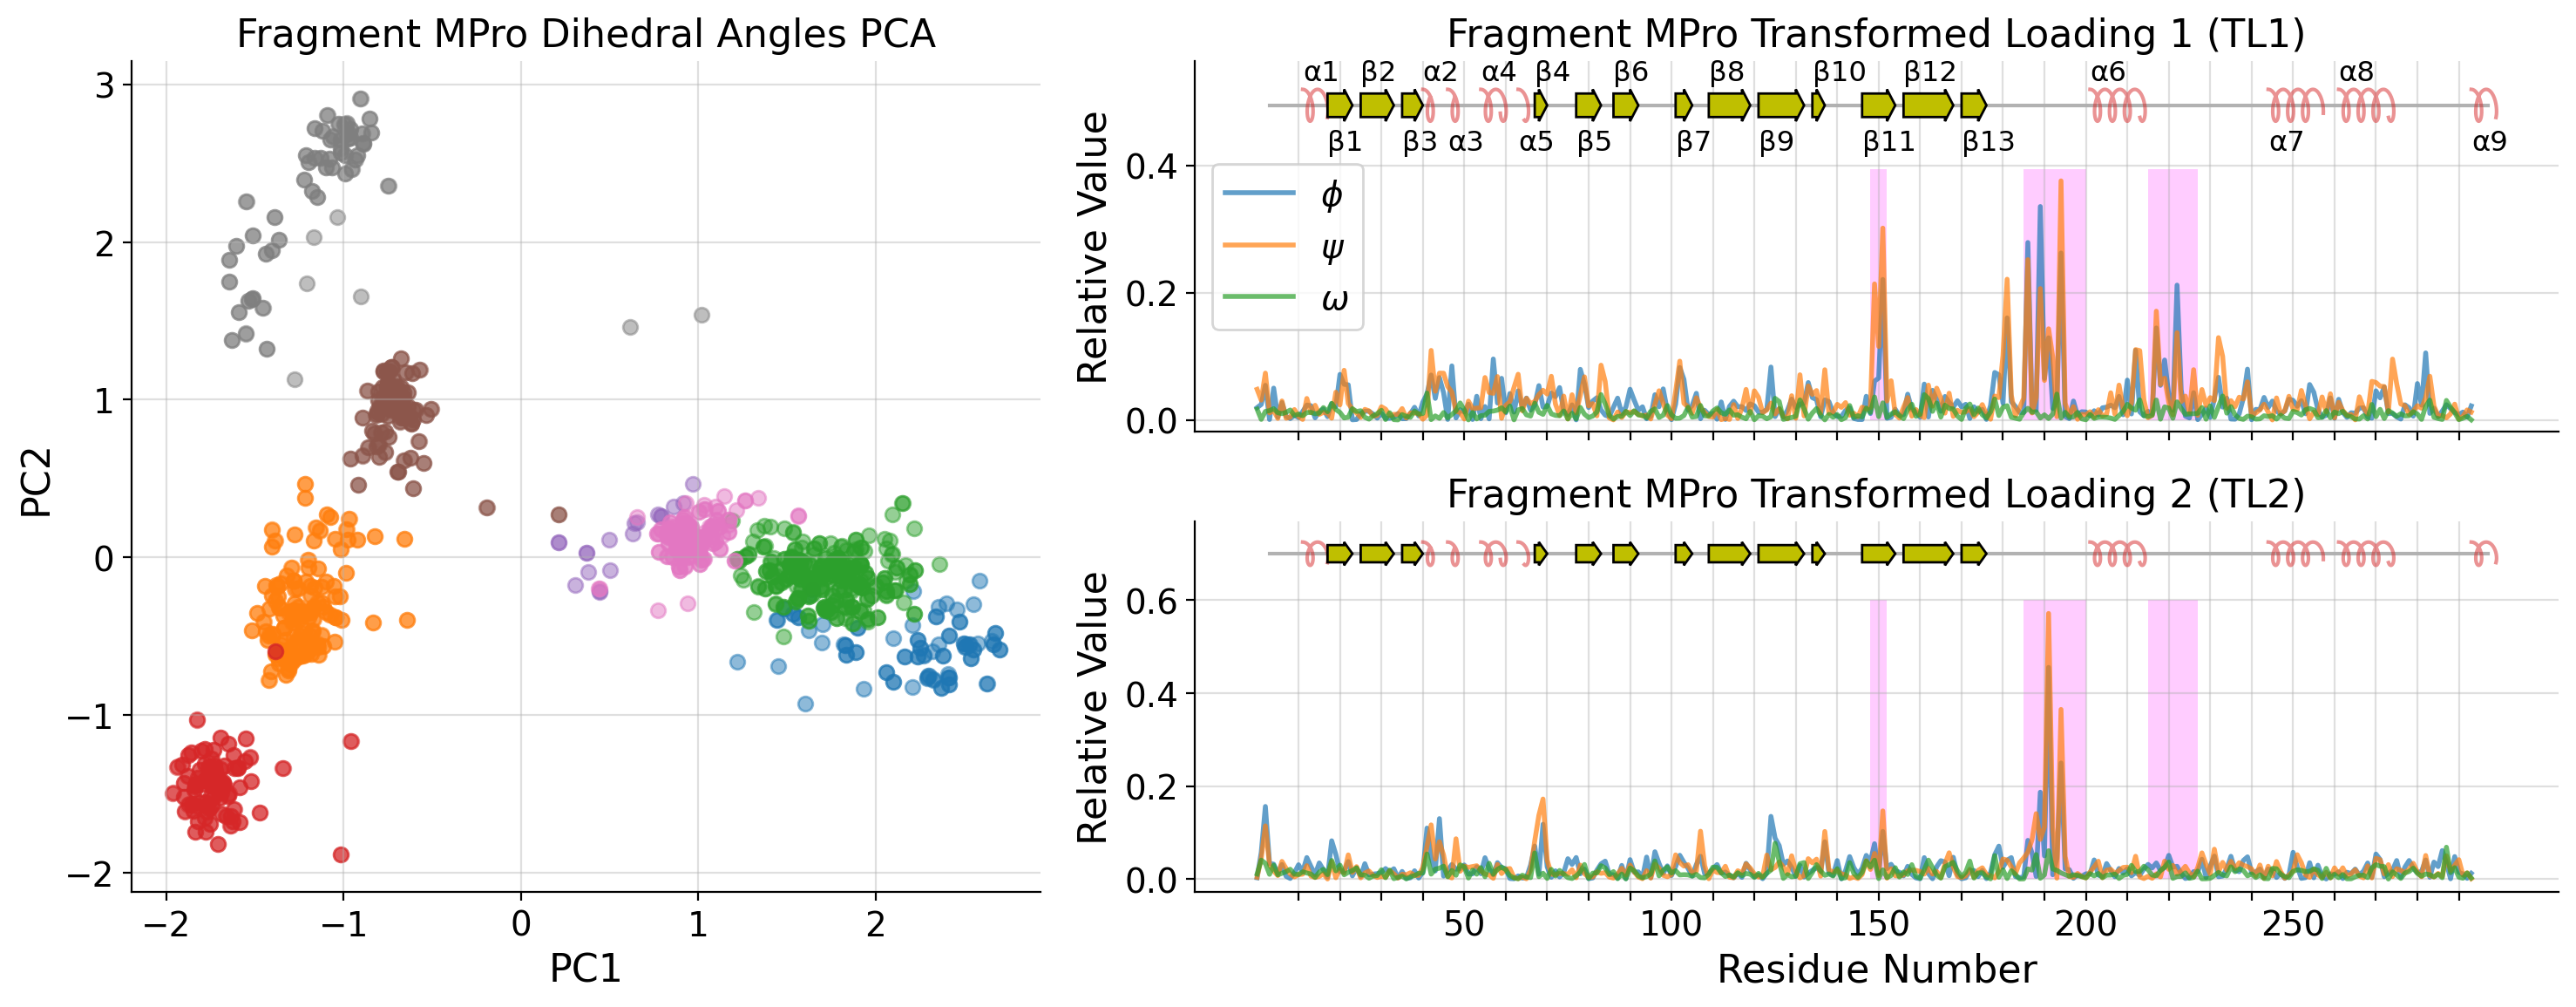

In [21]:
gs_kw = dict(width_ratios=[1, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic(
    [["left", "upper right"], ["left", "lower right"]],
    gridspec_kw=gs_kw,
    figsize=(15, 6),
    layout="constrained",
    dpi=200,
)

for i, ax in enumerate(axd):
    axd[ax].spines['top'].set_visible(False)
    axd[ax].spines['right'].set_visible(False)
    axd[ax].grid(alpha=0.4)
    
    if i == 0:
        for j in np.arange(8): 
            axd[ax].scatter(
                fragment_A[fragment_labels == j,0],
                fragment_A[fragment_labels == j,1],
                marker="o",
                alpha=0.5,
                edgecolor=None,
            )
        axd[ax].set_ylabel("PC2")
        axd[ax].set_xlabel("PC1")
        axd[ax].set_title("Fragment MPro Dihedral Angles PCA")

    else:
        psi_idx = np.arange(0, fragment_dihedrals_data_no_md.shape[1] // 2, 3)
        omg_idx = np.arange(1, fragment_dihedrals_data_no_md.shape[1] // 2, 3)
        phi_idx = np.arange(2, fragment_dihedrals_data_no_md.shape[1] // 2, 3)
        dh_range = np.arange(resnum_bounds[0], resnum_bounds[1] + 1)
        (phi_trace,) = axd[ax].plot(
            calculate_dh_tl(fragment_pca.components_[i - 1])[phi_idx],
            "-",
            label=r"$\phi$",
            linewidth=2,
            alpha=0.7,
        )
        (psi_trace,) = axd[ax].plot(
            calculate_dh_tl(fragment_pca.components_[i - 1])[psi_idx],
            "-",
            label=r"$\psi$",
            linewidth=2,
            alpha=0.7,
        )
        (omg_trace,) = axd[ax].plot(
            calculate_dh_tl(fragment_pca.components_[i - 1])[omg_idx],
            "-",
            label=r"$\omega$",
            linewidth=2,
            alpha=0.7,
        )
        ylims = axd[ax].get_ylim()
        axd[ax].set_title(f"Fragment MPro Transformed Loading {i} (TL{i})")
        axd[ax].set_xticks(
            [dh for dh in dh_range if dh % 10 == 0],
            labels=[dh if dh % 50 == 0 else '' for dh in dh_range if dh % 10 == 0],
        )
        axd[ax].add_patch(
            Rectangle(
                (148, 0),
                width=4,
                height=axd[ax].get_ylim()[1], # residues 148-152
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].add_patch(
            Rectangle(
                (185, 0),
                width=15,
                height=axd[ax].get_ylim()[1], # linker residues 185-200
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].add_patch(
            Rectangle(
                (215, 0),
                width=12,
                height=axd[ax].get_ylim()[1], # residues 215-227
                facecolor="magenta",
                alpha=0.2,
                fill=True,
            )
        )
        axd[ax].plot(np.arange(3,298), [ylims[1]+0.1]*295, alpha=0.3, color='k', linestyle='-', zorder=1)
        counter = 0
        for k,v in mpro_ss_dict.items(): 
            if k.startswith(u'\u03b1'): 
                ts = np.linspace(v[0], v[1], num=1000)
                axd[ax].plot(ts + 1.5*np.sin((ts-v[0])*2*np.pi/3.6), 0.025*np.cos((ts-v[0])*2*np.pi/3.6)+ylims[1]+0.1, color='tab:red', alpha=0.5, zorder=2)
                if ax == 'upper right': 
                    axd[ax].text(v[0], ylims[1]+0.14 if counter%2 == 0 else ylims[1]+0.03, k, fontsize='small')
                    counter += 1
            else: 
                axd[ax].arrow(v[0],ylims[1]+0.1,v[1]-v[0]+1,0, width=0.037, head_width=0.05, head_length=2, fc='y', length_includes_head=True, zorder=3)
                if ax == 'upper right': 
                    axd[ax].text(v[0], ylims[1]+0.14 if counter%2 == 0 else ylims[1]+0.03, k, fontsize='small')
                    counter += 1
        axd[ax].set_ylim((ylims[0], ylims[1]+0.17))
        axd[ax].set_ylabel("Relative Value")
axd["upper right"].set_xticklabels([])
axd["upper right"].legend(loc="center left")
axd["lower right"].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

In [22]:
# transition between PDB structures and fragalysis structures is at index 1112 (J0013_0A_chainA)

In [ ]:
calculate_coverage_matching_scores(pdb_strucs_no_md, fragment_strucs_no_md, (3,297), rmsd_threshold=1.0)
# coverage = , matching =  (this script took several hours to run)
# print(f'coverage =  and matching = ')

In [ ]:
# allosteric steering
gs_kw = dict(width_ratios=[1, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic(
    [["left", "upper right"], ["left", "lower right"]],
    gridspec_kw=gs_kw,
    figsize=(18, 8),
    layout="constrained",
    dpi=200,
)
pc1_idxs = np.argsort(u_A[:, 0])
pc2_idxs = np.argsort(u_A[:, 1])
idx_list = [pc1_idxs, pc2_idxs]
for idx, ax in enumerate(axd):
    axd[ax].spines['top'].set_visible(False)
    axd[ax].spines['right'].set_visible(False)
    axd[ax].grid(alpha=0.4)
    
    if idx == 0:
        pass
    else:
        axd[ax].scatter(
            np.arange(u_A.shape[0]), 
            u_A[idx_list[idx-1], idx-1],
            marker="o",
            alpha=0.5,
            edgecolor=None,
            color=np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])[km.labels_[idx_list[idx-1]]]
        )
        axd[ax].set_ylabel(f"PC{idx} z-score")
        axd[ax].set_title(f"MPro Structures Ordered by PC{idx}")
        axd[ax].set_xlim(left=-20, right=u_A.shape[0] + 20)
#         axd[ax].
axd["upper right"].set_xticklabels([])
axd["lower right"].set_xlabel("Structures")
plt.tight_layout()
plt.show()

## Supplementary figures

In [ ]:
# PC space plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax = ax.flatten()
pca_list = [u_A, rope_A]
struc_list_list = [dihedral_strucs_no_md, rope_strucs]
title_list = ["Dihedral Angles", "RoPE Dihedral Angles"]

# get the labels for the RoPE structures 
# include labels for structures that are included by RoPE 
# but not by COLAV
rope_labels = list()
rope_found = False 
for rope in rope_strucs: 
    rope_found = False
    for i, struc in enumerate(dihedral_strucs_no_md): 
        if rope in struc: 
            rope_labels.append(km.labels_[i])
            rope_found = True
            break
    if rope_found == False: 
        rope_labels.append(9) # will exclude from plot 
rope_labels = np.array(rope_labels)
labels_list = [km.labels_, rope_labels]
        
# enumerate the axes and the list of the PCAs
for i in np.arange(2):
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(alpha=0.4)

    for j in np.arange(8): 
        ax[i].scatter(
            pca_list[i][labels_list[i] == j,0],
            pca_list[i][labels_list[i] == j,1],
            marker="o",
            alpha=0.5,
            edgecolor=None,
        )

    ax[i].set_ylabel("PC2")
    ax[i].set_xlabel("PC1")
    ax[i].set_title("MPro " + title_list[i])
# ax[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
# PC space plots
fig, ax = plt.subplots(3, 3, figsize=(15,15), dpi=300)
ax = ax.flatten()
pca_list = [u_A]*3+[pw_A]*3+[sa_A]*3
struc_list_list = [dihedral_strucs_no_md]*3+[pw_strucs_no_md]*3+[sa_strucs_no_md]*3
title_list = [
    "Dihedral Angles", 
    "Dihedral Angles (PDB)", 
    "Dihedral Angles (Fragment Screen)",
    "Pairwise Distances", 
    "Pairwise Distances (PDB)", 
    "Pairwise Distances (Fragment Screen)", 
    "Strain Analysis",
    "Strain Analysis (PDB)", 
    "Strain Analysis (Fragment Screen)",
    
]
tmp_xlim = tuple()
tmp_ylim = tuple()
# enumerate the axes and the list of the PCAs
for i in np.arange(len(pca_list)):

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(alpha=0.4)
    
    if i%3 == 0: 
        ax[i].scatter(
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] < "A"
                    for x in struc_list_list[i]
                ],
                0,
            ],
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] < "A"
                    for x in struc_list_list[i]
                ],
                1,
            ],
            marker="o",
            alpha=0.5,
            edgecolor=None,
            color="#1f77b4",
            label="PDB"
        )
        ax[i].scatter(
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] > "A"
                    for x in struc_list_list[i]
                ],
                0,
            ],
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] > "A"
                    for x in struc_list_list[i]
                ],
                1,
            ],
            marker="o",
            alpha=0.5,
            edgecolor=None,
            color="#ff7f0e",
            label="Fragment Screen"
        )
        ax[i].legend(loc="best")
        tmp_xlim = ax[i].get_xlim()
        tmp_ylim = ax[i].get_ylim()
    elif i%3 == 1:
        ax[i].scatter(
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] < "A"
                    for x in struc_list_list[i]
                ],
                0,
            ],
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] < "A"
                    for x in struc_list_list[i]
                ],
                1,
            ],
            marker="o",
            alpha=0.5,
            edgecolor=None,
            color="#1f77b4",
        )
        ax[i].set_xlim(tmp_xlim)
        ax[i].set_ylim(tmp_ylim)
    else:
        ax[i].scatter(
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] > "A"
                    for x in struc_list_list[i]
                ],
                0,
            ],
            pca_list[i][
                [
                    os.path.basename(x).split("_")[1][0] > "A"
                    for x in struc_list_list[i]
                ],
                1,
            ],
            marker="o",
            alpha=0.5,
            edgecolor=None,
            color="#ff7f0e",
        )
        ax[i].set_xlim(tmp_xlim)
        ax[i].set_ylim(tmp_ylim)
    ax[i].set_ylabel("PC2")
    ax[i].set_xlabel("PC1")
    ax[i].set_title(title_list[i])
plt.tight_layout()
plt.show()

In [ ]:
# calculate t-SNE and UMAP
u_tsne = TSNE(random_state=0)
u_umap = UMAP(n_neighbors=50, random_state=0)
u_tsne_transform = u_tsne.fit_transform(untreated_dihedrals_data_no_md)
u_umap_transform = u_umap.fit_transform(untreated_dihedrals_data_no_md)

pw_tsne = TSNE(random_state=0)
pw_umap = UMAP(n_neighbors=50, random_state=0)
pw_tsne_transform = pw_tsne.fit_transform(pw_data_no_md)
pw_umap_transform = pw_umap.fit_transform(pw_data_no_md)

sa_tsne = TSNE(random_state=0)
sa_umap = UMAP(n_neighbors=50, random_state=0)
sa_tsne_transform = sa_tsne.fit_transform(sa_data_no_md)
sa_umap_transform = sa_umap.fit_transform(sa_data_no_md)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15), dpi=200)
ax = ax.flatten()
transform_list = [
    u_A,
    u_tsne_transform,
    u_umap_transform,
    pw_A,
    pw_tsne_transform,
    pw_umap_transform,
    sa_A,
    sa_tsne_transform,
    sa_umap_transform
]
struc_list_list = [
    dihedral_strucs_no_md,
    dihedral_strucs_no_md,
    dihedral_strucs_no_md,
    pw_strucs_no_md,
    pw_strucs_no_md,
    pw_strucs_no_md,
    sa_strucs_no_md,
    sa_strucs_no_md,
    sa_strucs_no_md
]
title_list = [
    "Dihedral Angles PCA",
    "Dihedral Angles t-SNE",
    "Dihedral Angles UMAP",
    "Pairwise Distances PCA",
    "Pairwise Distances t-SNE",
    "Pairwise Distances UMAP",
    "Strain Analysis PCA",
    "Strain Analysis t-SNE",
    "Strain Analysis UMAP"
]

for i in np.arange(len(transform_list)):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(alpha=0.4)
    
    if i >= 6: 
        for j in np.arange(8):
            ax[i].scatter(
                transform_list[i][np.array(tmp) == j, 0],
                transform_list[i][np.array(tmp) == j, 1],
                marker="o",
                alpha=0.5,
                edgecolor=None,
            )
    else: 
        for j in np.arange(8):
            ax[i].scatter(
                transform_list[i][km.labels_ == j, 0],
                transform_list[i][km.labels_ == j, 1],
                marker="o",
                alpha=0.5,
                edgecolor=None,
            )
    ax[i].set_ylabel("Coordinate 2")
    ax[i].set_xlabel("Coordinate 1")
    ax[i].set_title(f"MPro {title_list[i]}")
plt.tight_layout()
plt.show()

In [ ]:
# create array for storing correlation coefficients
dh_pw_matrix = list()
dh_sa_matrix = list()
pw_sa_matrix = list()
psi_idx = np.arange(0, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
omg_idx = np.arange(1, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
phi_idx = np.arange(2, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
# load the shared atom data
shared_atom_set = pickle.load(open("mpro_data/mpro_atom_set.pkl", "rb"))

for i in np.arange(10):
    for j in np.arange(10):
        # calculate the correlation coefficients
        dh_pw_matrix.append(
            pearsonr(
                calculate_dh_tl(u_pca.components_[i, :])[psi_idx]
                + calculate_dh_tl(u_pca.components_[i, :])[phi_idx]
                + calculate_dh_tl(u_pca.components_[i, :])[omg_idx],
                calculate_pw_tl(pw_pca.components_[j, :], resnum_bounds)[1:],
            )[0]
        )
        dh_sa_matrix.append(
            pearsonr(
                (calculate_dh_tl(u_pca.components_[i, :])[psi_idx]
                + calculate_dh_tl(u_pca.components_[i, :])[phi_idx]
                + calculate_dh_tl(u_pca.components_[i, :])[omg_idx])[2:],
                calculate_sa_tl(sa_pca.components_[j, :], sorted(shared_atom_set)),
            )[0]
        )
        pw_sa_matrix.append(
            pearsonr(
                calculate_pw_tl(pw_pca.components_[i, :], resnum_bounds)[3:],
                calculate_sa_tl(sa_pca.components_[j, :], sorted(shared_atom_set)),
            )[0]
        )
        
dh_pw_matrix = np.array(dh_pw_matrix).reshape(10, 10)
dh_sa_matrix = np.array(dh_sa_matrix).reshape(10, 10)
pw_sa_matrix = np.array(pw_sa_matrix).reshape(10, 10)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
ax = ax.flatten()
axs_list = [("Dihedral Angles", "C\u03b1 Pairwise Distances"), ("Dihedral Angles", "Strain Analysis"), ("C\u03b1 Pairwise Distances", "Strain Analysis")]
dot_matrix_list = [dh_pw_matrix, dh_sa_matrix, pw_sa_matrix]
for i in np.arange(3):
    im = ax[i].imshow(dot_matrix_list[i], cmap="cividis", interpolation=None)
    ax[i].set_xlabel(f"{axs_list[i][0]} TLs")
    ax[i].set_ylabel(f"{axs_list[i][1]} TLs")
    ax[i].set_title(f"TL Comparison of {axs_list[i][0]} \nand {axs_list[i][1]}")
    ax[i].set_xticks(np.arange(10), labels=np.arange(1,11))
    ax[i].set_yticks(np.arange(10), labels=np.arange(1,11))
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

In [ ]:
rope_pca.components_[0,12:].shape, u_pca.components_[0,:].shape

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
dot_matrix = list()
for i in np.arange(10):
    for j in np.arange(10):
        dot_matrix.append(
            pearsonr(
                calculate_dh_tl(rope_pca.components_[i, :-12]), # I am not sure if this is right; need to double check 
                calculate_dh_tl(u_pca.components_[j, :]),
            )[0]
        )

dot_matrix = np.array(dot_matrix).reshape(10, 10)
im = ax.imshow(dot_matrix, cmap="cividis", interpolation=None)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax = ax.flatten()
dot_matrix_all = list()
dot_matrix_pdb = list()
for i in np.arange(10):
    for j in np.arange(10):
        dot_matrix_all.append(
            pearsonr(
                calculate_dh_tl(u_pca.components_[i, :]),
                calculate_dh_tl(fragment_pca.components_[j, :]),
            )[0]
        )
        dot_matrix_pdb.append(
            pearsonr(
                calculate_dh_tl(pdb_pca.components_[i, :]),
                calculate_dh_tl(fragment_pca.components_[j, :]),
            )[0]
        )

dot_matrix_all = np.array(dot_matrix_all).reshape(10, 10)
dot_matrix_pdb = np.array(dot_matrix_pdb).reshape(10, 10)
for i in np.arange(2): 
    im = ax[i].imshow(dot_matrix_all if i == 0 else dot_matrix_pdb, cmap="cividis", interpolation=None)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    ax[i].set_xlabel("Fragment TLs")
    ax[i].set_ylabel("All TLs" if i == 0 else "PDB TLs")
    ax[i].set_title("PTP-1B TL Comparison of All\n and Fragment Datasets" if i == 0 else "PTP-1B TL Comparison of PDB\n and Fragment Datasets")

plt.tight_layout()
plt.show()

plt.tight_layout()

ax.set_xlabel("RoPE TLs")
ax.set_ylabel("Untreated TLs")
ax.set_title("MPro TL Comparison of RoPE\n and Untreated Datasets")
# plt.colorbar(im)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax = ax.flatten()
dot_matrix_all = list()
dot_matrix_pdb = list()
for i in np.arange(10):
    for j in np.arange(10):
        dot_matrix_all.append(
            pearsonr(
                calculate_dh_tl(u_pca.components_[i, :]),
                calculate_dh_tl(fragment_pca.components_[j, :]),
            )[0]
        )
        dot_matrix_pdb.append(
            pearsonr(
                calculate_dh_tl(pdb_pca.components_[i, :]),
                calculate_dh_tl(fragment_pca.components_[j, :]),
            )[0]
        )

dot_matrix_all = np.array(dot_matrix_all).reshape(10, 10)
dot_matrix_pdb = np.array(dot_matrix_pdb).reshape(10, 10)
for i in np.arange(2): 
    im = ax[i].imshow(dot_matrix_all if i == 0 else dot_matrix_pdb, cmap="cividis", interpolation=None)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    ax[i].set_xlabel("Fragment TLs")
    ax[i].set_ylabel("All TLs" if i == 0 else "PDB TLs")
    ax[i].set_title("MPro TL Comparison of All\n and Fragment Datasets" if i == 0 else "MPro TL Comparison of PDB\n and Fragment Datasets")

plt.tight_layout()
plt.show()

In [ ]:
# dihedral angles 
r = 10
r_list = [r - 1, r - 2]
fig, ax = plt.subplots(r // 2, 2, figsize=(15, 15), dpi=200)
ax = ax.flatten()
psi_idx = np.arange(0, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
omg_idx = np.arange(1, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
phi_idx = np.arange(2, untreated_dihedrals_data_no_md.shape[1] // 2, 3)
dh_range = np.arange(resnum_bounds[0], resnum_bounds[1] + 1)
for k in np.arange(r):
    (phi_trace,) = ax[k].plot(
        calculate_dh_tl(u_pca.components_[k])[phi_idx],
        "-",
        label=r"$\phi$",
        linewidth=2,
        alpha=0.5,
    )
    (psi_trace,) = ax[k].plot(
        calculate_dh_tl(u_pca.components_[k])[psi_idx],
        "-",
        label=r"$\psi$",
        linewidth=2,
        alpha=0.5,
    )
    (omg_trace,) = ax[k].plot(
        calculate_dh_tl(u_pca.components_[k])[omg_idx],
        "-",
        label=r"$\omega$",
        linewidth=2,
        alpha=0.5,
    )
#     ax[k].add_patch(
#         Rectangle(
#             (185, 0),
#             width=15,
#             height=ax[k].get_ylim()[1], # linker residues 185-200
#             facecolor="tab:cyan",
#             alpha=0.25,
#             fill=True,
#         )
#     )
#     ax[k].add_patch(
#         Rectangle(
#             (215, 0),
#             width=10,
#             height=ax[k].get_ylim()[1], # linker residues 218-227
#             facecolor="magenta",
#             alpha=0.25,
#             fill=True,
#         )
#     )
#     ax[k].add_patch(
#         Rectangle(
#             (148, 0),
#             width=4,
#             height=ax[k].get_ylim()[1], # linker residues 218-227
#             facecolor="magenta",
#             alpha=0.25,
#             fill=True,
#         )
#     )
    ax[k].set_title(f"MPro DH Transformed Loading {k+1} (TL{k+1})")
    ax[k].set_xticks(
        [dh for dh in dh_range if dh % 50 == 0],
        labels=[dh for dh in dh_range if dh % 50 == 0],
    )
    ax[k].set_yticks(
        np.arange(0, ax[k].get_yticks().max(), 0.1),
        labels=np.round(np.arange(0, ax[k].get_yticks().max(), 0.1), 2),
    )
    ax[k].set_ylabel("Relative Value")
    if k not in r_list:
        ax[k].set_xticklabels([])
ax[0].legend(loc="upper left")
ax[-1].set_xlabel("Residue Number")
ax[-2].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

In [ ]:
# pairwise distances tranformed loadings
r = 10
r_list = [r - 1, r - 2]
fig, ax = plt.subplots(r // 2, 2, figsize=(15, 15), dpi=200)
ax = ax.flatten()

for k in np.arange(r):
    ax[k].plot(
        np.arange(resnum_bounds[0], resnum_bounds[1] + 1),
        calculate_pw_tl(pw_pca.components_[k], resnum_bounds),
        "-",
        linewidth=2,
        alpha=0.5,
    )
    ax[k].set_title(f"MPro PW Transformed Loading {k+1} (TL{k+1})")
    ax[k].set_xticks(
        [x for x in np.arange(resnum_bounds[0], resnum_bounds[1] + 1) if x % 50 == 0],
        labels=[
            x for x in np.arange(resnum_bounds[0], resnum_bounds[1]) if x % 50 == 0
        ],
    )
#     ax[k].add_patch(
#         Rectangle(
#             (185, 0),
#             width=15,
#             height=ax[k].get_ylim()[1], # linker residues 185-200
#             facecolor="tab:cyan",
#             alpha=0.25,
#             fill=True,
#         )
#     )
#     ax[k].add_patch(
#         Rectangle(
#             (218, 0),
#             width=10,
#             height=ax[k].get_ylim()[1], # linker residues 218-227
#             facecolor="magenta",
#             alpha=0.25,
#             fill=True,
#         )
#     )
    ax[k].set_ylabel("Relative Value")
    if k not in r_list:
        ax[k].set_xticklabels([])
ax[-1].set_xlabel("Residue Number")
ax[-2].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

In [ ]:
# strain analysis tranformed loadings
r = 10
r_list = [r - 1, r - 2]
fig, ax = plt.subplots(r // 2, 2, figsize=(15, 15), dpi=200)
ax = ax.flatten()
shared_atom_set = pickle.load(open("mpro_data/mpro_atom_set.pkl", "rb"))

for k in np.arange(r):
    ax[k].plot(
        calculate_sa_tl(sa_pca.components_[k], sorted(shared_atom_set)),
        "-",
        linewidth=2,
        alpha=0.5,
    )
    ax[k].set_title(f"MPro SA Transformed Loading {k+1} (TL{k+1})")
    ax[k].set_xticks(
        [x for x in np.arange(resnum_bounds[0], resnum_bounds[1] + 1) if x % 50 == 0],
        labels=[
            x for x in np.arange(resnum_bounds[0], resnum_bounds[1]) if x % 50 == 0
        ],
    )
#     ax[k].add_patch(
#         Rectangle(
#             (185, 0),
#             width=15,
#             height=ax[k].get_ylim()[1], # linker residues 185-200
#             facecolor="tab:cyan",
#             alpha=0.25,
#             fill=True,
#         )
#     )
#     ax[k].add_patch(
#         Rectangle(
#             (218, 0),
#             width=10,
#             height=ax[k].get_ylim()[1], # linker residues 218-227
#             facecolor="magenta",
#             alpha=0.25,
#             fill=True,
#         )
#     )
    ax[k].set_ylabel("Relative Value")
    if k not in r_list:
        ax[k].set_xticklabels([])
ax[-1].set_xlabel("Residue Number")
ax[-2].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()